# 1. Introduction

In [ ]:
import sys
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf

# Project root is the parent of the notebooks/ folder
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))
from src.utils.config import load_config

cfg = load_config()
PANEL_PATH = PROJECT_ROOT / "data" / "processed" / "prices_ohlcv_panel.parquet"

TICKER_TARGET = "AMD"  

---
# 2. Data loading
Get the processed data.

In [55]:
# Load multi-asset OHLCV panel
panel = pd.read_parquet(PANEL_PATH)
panel = panel.sort_index()

print(panel.shape)
panel.head()

(3268, 126)


ticker                    AAPL                                              \
field                    close       high        low       open     volume   
date                                                                         
2012-01-03 23:00:00  12.399499  12.436689  12.274737  12.296330  260022000   
2012-01-04 23:00:00  12.537153  12.552748  12.376401  12.444781  271269600   
2012-01-05 23:00:00  12.668217  12.678713  12.572845  12.589340  318292800   
2012-01-08 23:00:00  12.648123  12.828669  12.636726  12.761190  394024400   
2012-01-09 23:00:00  12.693412  12.776187  12.641227  12.773488  258196400   

ticker                                                             MSFT  ...  \
field               daily_return log_return     range is_gap      close  ...   
date                                                                     ...   
2012-01-03 23:00:00     0.005375   0.005360  0.161952   True  21.458832  ...   
2012-01-04 23:00:00     0.011102   0.011040  0.176347   True  21.678125  ...   
2012-01-05 23:00:00     0.010454   0.010400  0.105868   True  22.014877  ...   
2012-01-08 23:00:00    -0.001586  -0.001587  0.191943   True  21.725115  ...   
2012-01-09 23:00:00     0.003581   0.003574  0.134960   True  21.803427  ...   

ticker                ^NDX       ^VIX                                          \
field               is_gap      close       high        low       open volume   
date                                                                            
2012-01-03 23:00:00   True  22.219999  23.730000  22.219999  23.440001      0   
2012-01-04 23:00:00   True  21.480000  23.090000  21.340000  22.750000      0   
2012-01-05 23:00:00   True  20.629999  21.719999  20.580000  21.240000      0   
2012-01-08 23:00:00   True  21.070000  21.780001  21.000000  21.670000      0   
2012-01-09 23:00:00   True  20.690001  20.690001  20.049999  20.139999      0   

ticker                                                        
field               daily_return log_return     range is_gap  
date                                                          
2012-01-03 23:00:00    -0.032651  -0.033196  1.510000   True  
2012-01-04 23:00:00    -0.033303  -0.033871  1.750000   True  
2012-01-05 23:00:00    -0.039572  -0.040376  1.139999   True  
2012-01-08 23:00:00     0.021328   0.021104  0.780001   True  
2012-01-09 23:00:00    -0.018035  -0.018200  0.640001   True  

[5 rows x 126 columns]

In [68]:
# some dataframes for easier access
sample_tickers = cfg["data"]["tickers"][:5]
tickers = cfg["data"]["tickers"]
indexes = cfg["data"]["indexes"]

all_tickers = tickers + indexes

In [5]:
# Convenience views
close = panel.xs("close", axis=1, level="field")
volume = panel.xs("volume", axis=1, level="field")

# Check target ticker
close[TICKER_TARGET].head()

date
2012-01-03 23:00:00    5.46
2012-01-04 23:00:00    5.46
2012-01-05 23:00:00    5.43
2012-01-08 23:00:00    5.59
2012-01-09 23:00:00    5.71
Name: AMD, dtype: float64

---
# 3. Univariate analysis


## 3.1. Time Series Plots

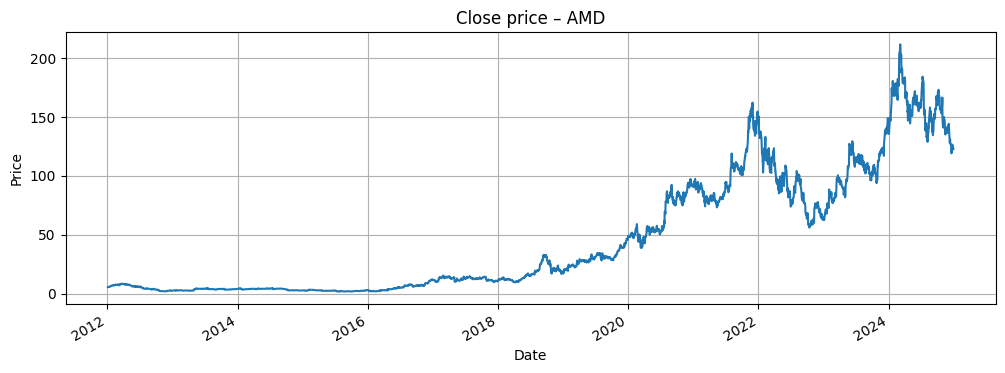

In [14]:

plt.figure(figsize=(12, 4))
close[TICKER_TARGET].plot()
plt.title(f"Close price – {TICKER_TARGET}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


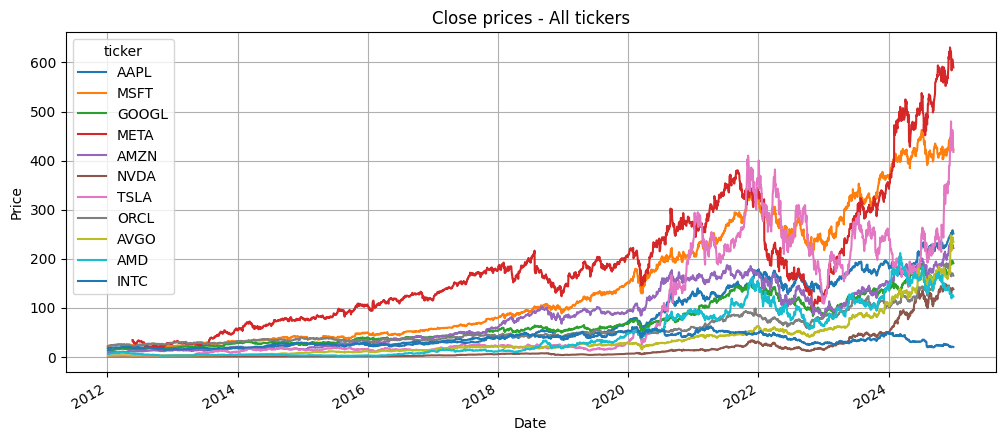

In [74]:
close[tickers].plot(figsize=(12, 5))
plt.title("Close prices - All tickers")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

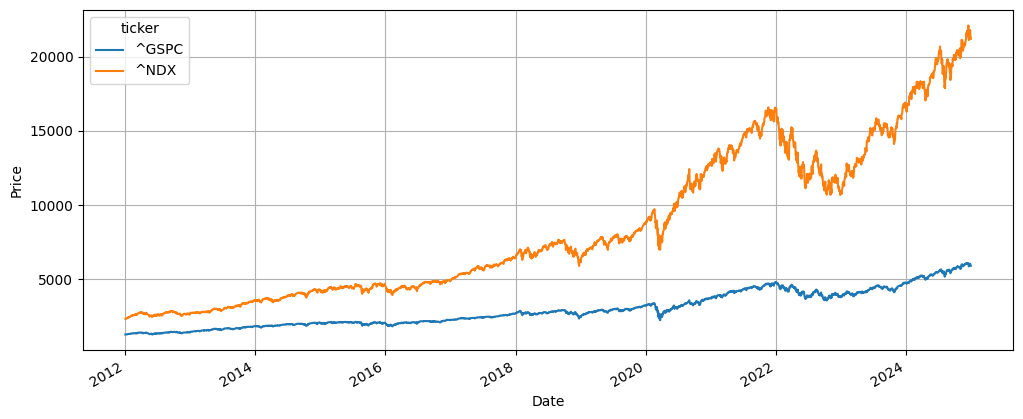

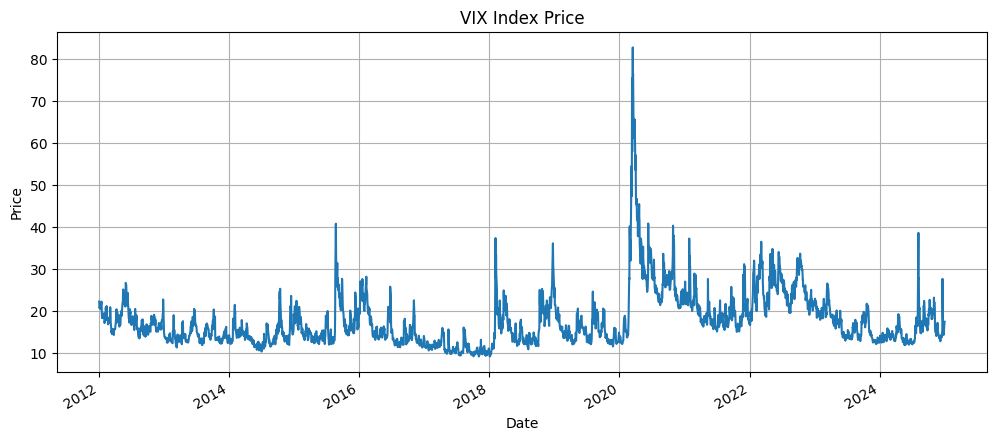

In [66]:
close[indexes[:2]].plot(figsize=(12, 5))
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

close[indexes[-1]].plot(figsize=(12, 5))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("VIX Index Price")
plt.grid(True)
plt.show()


## 3.2. Return Distributions (Histograms)


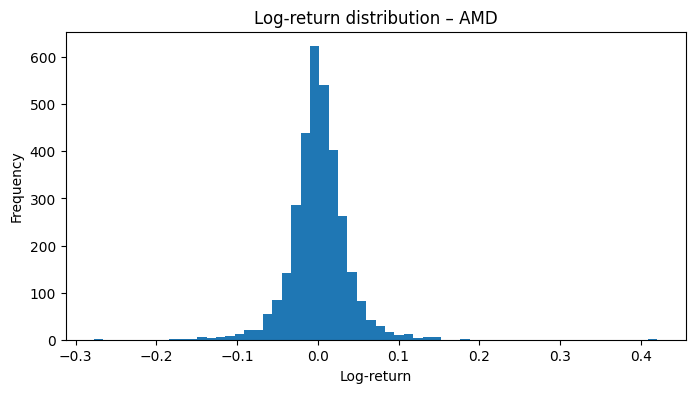

In [15]:
log_ret = np.log(close / close.shift(1))

plt.figure(figsize=(8, 4))
log_ret[TICKER_TARGET].dropna().hist(bins=60)
plt.title(f"Log-return distribution – {TICKER_TARGET}")
plt.xlabel("Log-return")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

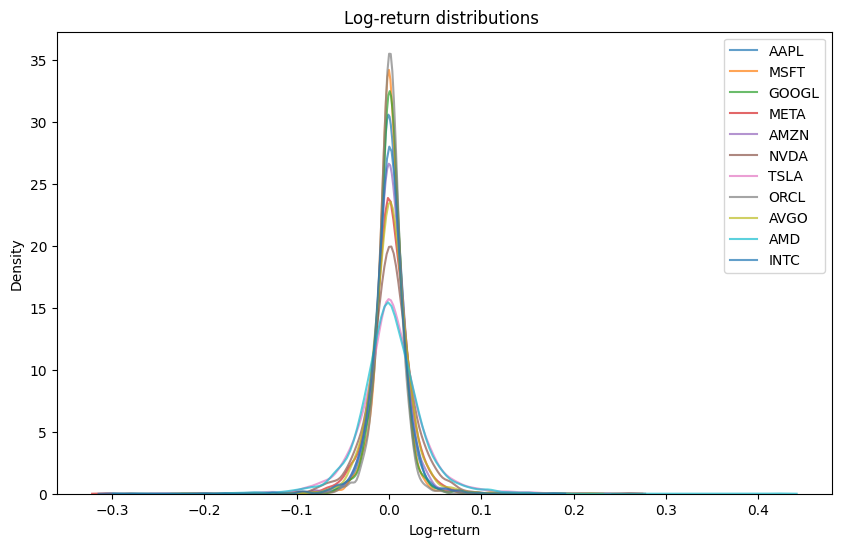

In [73]:
plt.figure(figsize=(10, 6))
for t in tickers:
    sns.kdeplot(log_ret[t].dropna(), label=t, alpha=0.7)
plt.title("Log-return distributions ")
plt.xlabel("Log-return")
plt.legend()
plt.show()

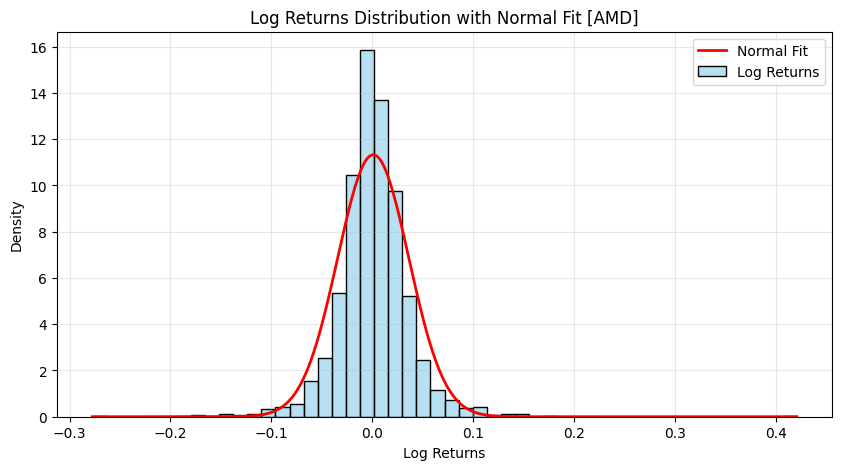

In [30]:
# Compute log-returns
log_ret = np.log(close / close.shift(1))
series = log_ret[TICKER_TARGET].dropna()

# Fit a normal distribution
mu, sigma = norm.fit(series)
x = np.linspace(series.min(), series.max(), 500)
pdf = norm.pdf(x, mu, sigma)

plt.figure(figsize=(10, 5))

# Histogram of log-returns
sns.histplot(series, bins=50, kde=False, stat="density", color="skyblue", alpha=0.6, label="Log Returns")

# Normal distribution curve
plt.plot(x, pdf, "r-", linewidth=2, label="Normal Fit")

plt.title(f"Log Returns Distribution with Normal Fit [{TICKER_TARGET}]")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
stats_summary = {
    "Mean": series.mean(),
    "Std Dev": series.std(),
    "Skewness": skew(series),
    "Kurtosis": kurtosis(series, fisher=False)  # >3 means fat tails
}

stats_summary

{'Mean': np.float64(0.0009519964301418384),
 'Std Dev': np.float64(0.03523122699592582),
 'Skewness': np.float64(0.28018093425275364),
 'Kurtosis': np.float64(13.033814104583191)}

- **Mean close to zero:** expected for daily log-returns of large-cap equities.

- **High central peak:** indicates that most returns cluster around zero (low daily movement).

- **Fat tails (kurtosis > 3):** more extreme events than a Gaussian model would predict.

- **Negative skewness:** left tail is larger → downside moves tend to be stronger than upside moves.

- **Normal fit is clearly imperfect:** highlights why linear-Gaussian models are insufficient for forecasting.

## 3.3. Boxplots


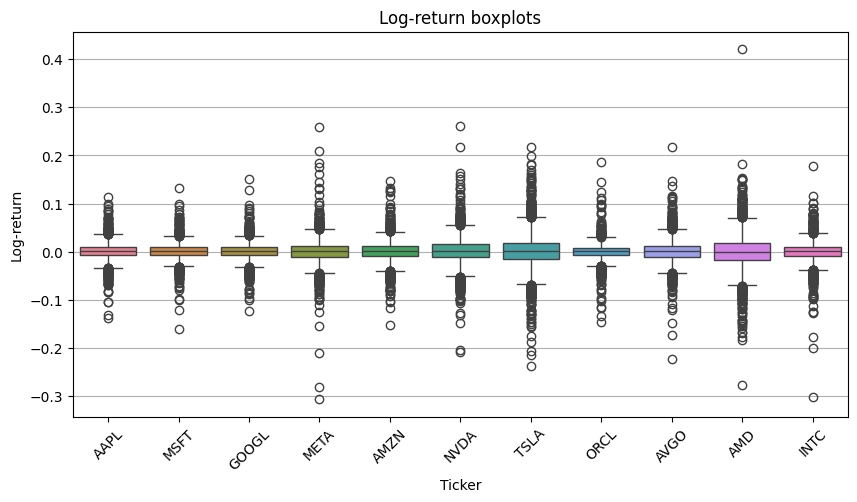

In [71]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=log_ret[tickers],
)
plt.title("Log-return boxplots")
plt.xlabel("Ticker")
plt.ylabel("Log-return")
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.show()

- Confirms that returns are heavy-tailed and not Gaussian -> beneficial to engineer volatility-based features.

- Justifies treating each asset independently for the target variable (y = 1 if next_return > 0 else 0).

- Highlights that extreme events are frequent → LSTMs may capture temporal dependence in volatility rather than the mean.


## 3.4 Autocorrelation function (ACF)


<Figure size 800x400 with 0 Axes>

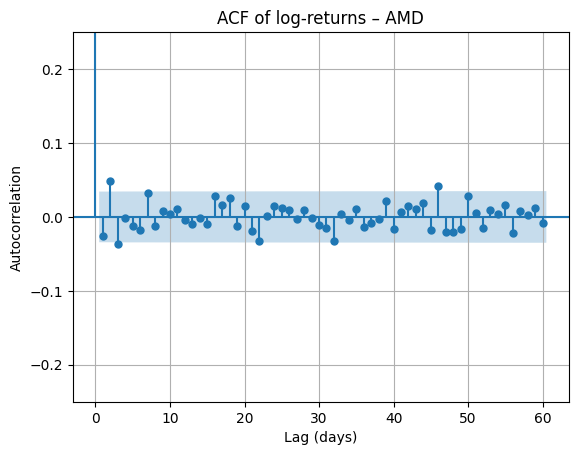

In [75]:
series = log_ret[TICKER_TARGET].dropna()

plt.figure(figsize=(8, 4))
plot_acf(series, lags=60)
plt.title(f"ACF of log-returns – {TICKER_TARGET}")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.ylim([-0.25, 0.25])
plt.grid(True)
plt.show()

- Confirms that returns themselves do not exhibit linear autocorrelation.

- Suggests that the LSTM will mainly capture:
	-	Non-linear patterns,
	-	Volatility clustering,
	-	Regime shifts, not simple AR-style dependencies.

- Justifies using past windows (30–60 days) not to predict the mean but to capture state of volatility or market regime.


## 3.5 Rolling volatility

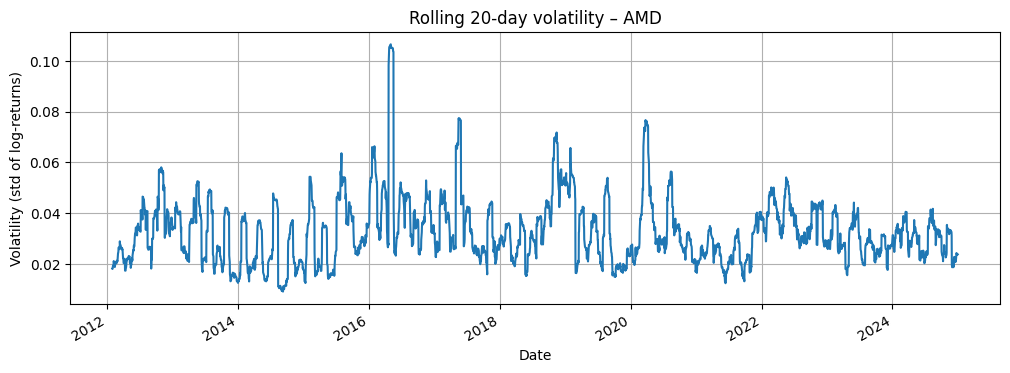

In [76]:
window = 20  # 1month approx

rolling_vol = log_ret[TICKER_TARGET].rolling(window).std()

plt.figure(figsize=(12, 4))
rolling_vol.plot()
plt.title(f"Rolling {window}-day volatility – {TICKER_TARGET}")
plt.xlabel("Date")
plt.ylabel("Volatility (std of log-returns)")
plt.grid(True)
plt.show()

<Figure size 1200x500 with 0 Axes>

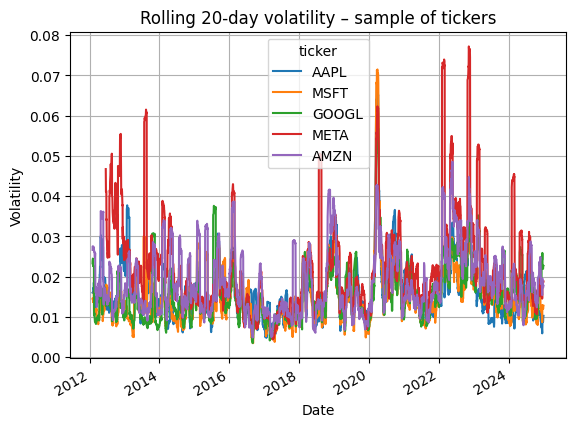

In [77]:
rolling_vol_multi = log_ret[sample_tickers].rolling(window).std()

plt.figure(figsize=(12, 5))
rolling_vol_multi.plot()
plt.title(f"Rolling {window}-day volatility – sample of tickers")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

- Rolling volatility shows a stronger temporal structure than returns themselves.

- This temporal structure can be leveraged by:
	- LSTMs,
	- volatility-based features,
	- PCA factors capturing market-wide shocks.

- Justifies including rolling-window features:
	- rolling std,
	- rolling mean return,
	- rolling min/max,
	- volatility ratios.

---
# 4. Multivariate analysis

## 4.1. Correlation heatmap


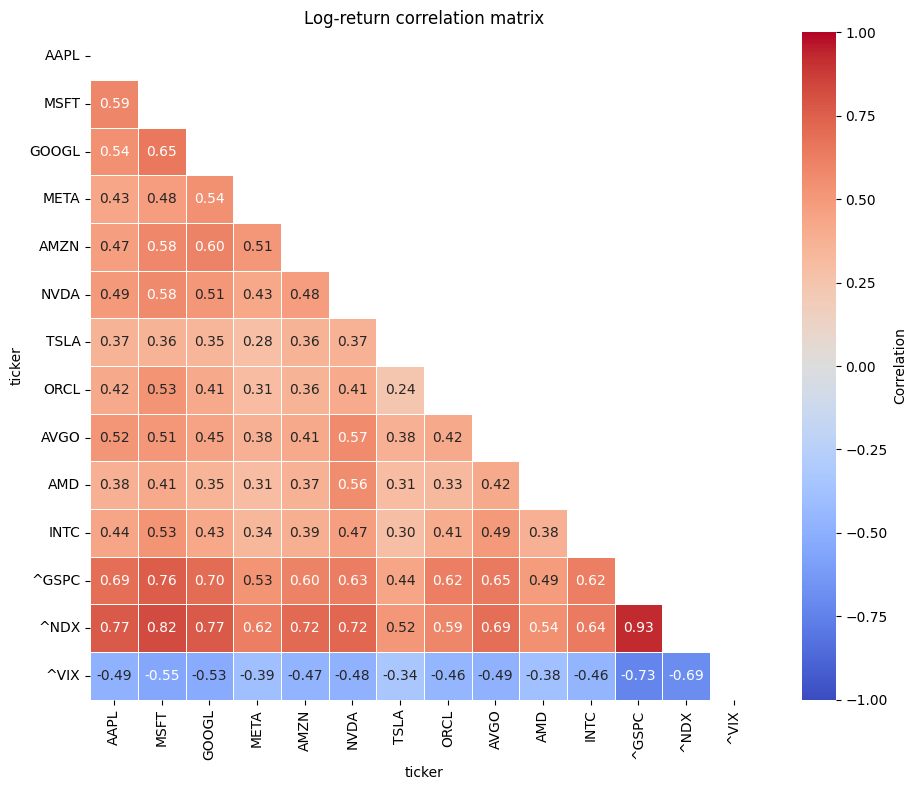

In [69]:
corr = log_ret[all_tickers].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# heatmap with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            annot=True,
            fmt='.2f',
            mask=mask,
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation'}
            )
plt.title("Log-return correlation matrix")
plt.tight_layout()
plt.show()

## 4.2. Variance structure

/var/folders/jq/xshncj9j3571ygk72m_rkz000000gn/T/ipykernel_87769/4085537037.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


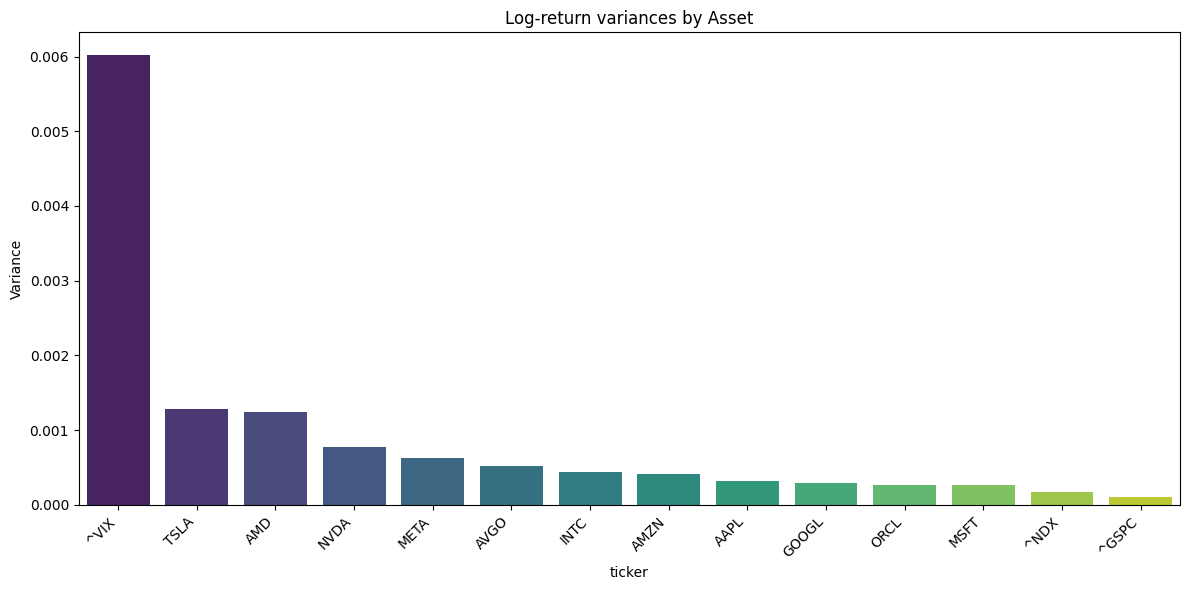

In [84]:
# variances of each asset
variances = log_ret[all_tickers].var().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(
    x=variances.index,
    y=variances.values,
    palette="viridis"
)

plt.xticks(rotation=45, ha="right")
plt.title("Log-return variances by Asset")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()

## 4.3. PCA

PCA has to be applied over standarized data (mainly because of VIX)

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(log_ret[all_tickers].dropna())

We will use 5 components

In [96]:
from sklearn.decomposition import PCA

pca_components = 5
pca = PCA(n_components=pca_components)
pca.fit(X_scaled)

expl_var = pca.explained_variance_ratio_

### Explained variance plot

/var/folders/jq/xshncj9j3571ygk72m_rkz000000gn/T/ipykernel_87769/380643383.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


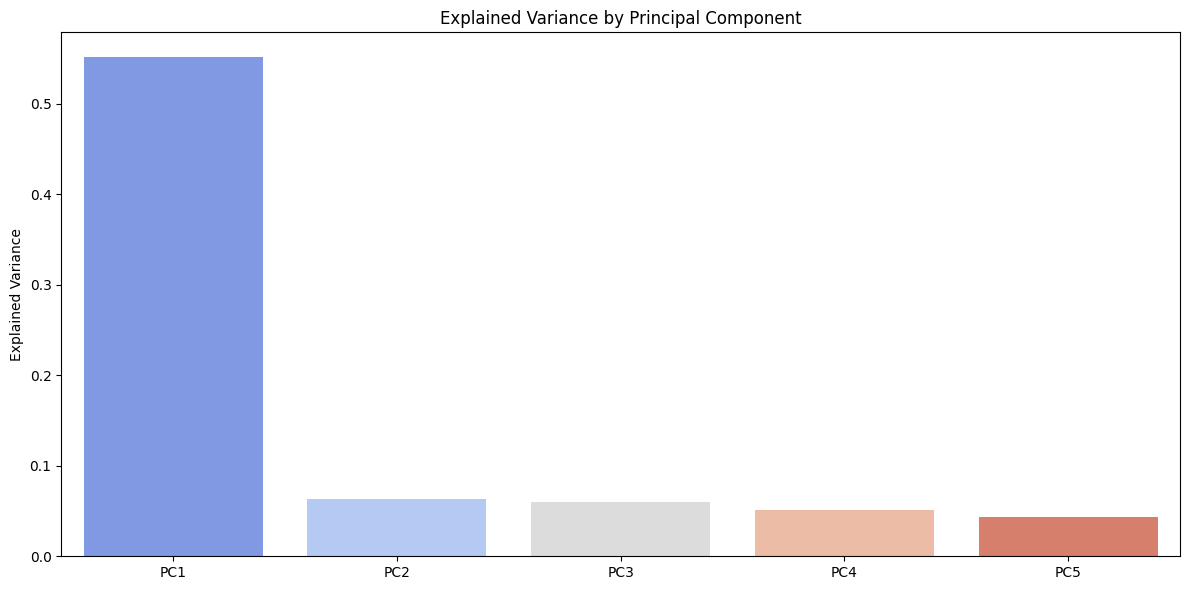

In [97]:
plt.figure(figsize=(12,6))
sns.barplot(
    x=[f"PC{i+1}" for i in range(len(expl_var))],
    y=expl_var,
    palette="coolwarm"
)

plt.title("Explained Variance by Principal Component")
plt.ylabel("Explained Variance")
plt.tight_layout()
plt.show()

### Factor loadings
This shows which assets have the most load on each factor

In [98]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=log_ret[all_tickers].columns,
    columns=[f"PC{i+1}" for i in range(pca_components)]
)

print(loadings.round(3))

          PC1    PC2    PC3    PC4    PC5
ticker                                   
AAPL    0.271 -0.057 -0.028  0.134  0.118
MSFT    0.299 -0.128 -0.129 -0.002 -0.061
GOOGL   0.281 -0.365  0.027 -0.059 -0.049
META    0.228 -0.465  0.226 -0.285  0.173
AMZN    0.262 -0.348  0.200 -0.116 -0.144
NVDA    0.271  0.274  0.168 -0.298  0.006
TSLA    0.191  0.168  0.607  0.675 -0.177
ORCL    0.227  0.104 -0.542  0.123 -0.549
AVGO    0.259  0.285 -0.003  0.092  0.371
AMD     0.213  0.500  0.275 -0.532 -0.306
INTC    0.241  0.247 -0.236  0.033  0.597
^GSPC   0.333 -0.003 -0.163  0.096 -0.019
^NDX    0.354 -0.059  0.011  0.030  0.026
^VIX   -0.264 -0.019  0.207 -0.149  0.087


With this values we can conclude what the components means:

- PC1 is clearly the market factor

- PC2 is probably the semiconductors sector

- PC3 is probably high volatility assets

- PC4 looks like TSLA vs the rest

- PC5 probably just noise.

### Component scores

In [99]:
pca_factors = pd.DataFrame(
    pca.transform(X_scaled),
    index=log_ret[all_tickers].dropna().index,
    columns=[f"PC{i+1}" for i in range(pca_components)]
)

pca_factors.head()

,PC1,PC2,PC3,PC4,PC5
date,,,,,
2012-05-21 22:00:00,-1.524794,2.447392,-0.141137,2.929125,-0.727028
2012-05-22 22:00:00,1.506410,-0.202839,0.479184,0.161862,0.533598
2012-05-23 22:00:00,-1.310321,-1.079270,0.010144,-0.566603,0.851527
2012-05-24 22:00:00,-0.570934,2.196727,-0.348755,-0.506485,0.079908
2012-05-28 22:00:00,2.054451,3.167200,-0.327307,1.988650,-0.762452


In [107]:
# to save the factors
OUT = PROJECT_ROOT / "data" / "processed"
OUT.mkdir(parents=True, exist_ok=True)

pca_factors.to_parquet(OUT / "pca_factors.parquet")